# Sincronización

La `sincronización` es un concepto en las ciencias de la computación que especifica ciertos tipo de mecanismo para asegurar que no más de una tarea (proceso/hilo) concurrente pueda procesar o ejectuar una porción del programa en un instante de tiempo. Esta porción de código se conoce como **sección crítica**. 

Cuando en un programa una tarea accede a una sección crítica las demás tareas tienen que esperar hasta finalizar la tarea que está en ejecución. El objetivo de la sincronización es evitar cualquier corrupción en el manejo de recursos compartidos, si solo una tarea ejecuta la sección crítica del programa en una única unidad de tiempo se garantiza que se evitará la aparición de conflictos provocados por las múltiples tareas producto de la concurrencia.

Los hilos o *threads* son procesos ligeros que se ejecutan en el mismo espacio de memoria, por tanto complica el uso de variables dado que múltiples hilos pueden escribir en la *misma localidad de memoria*, lo que no sucede con los procesos que deben utilizar un mecanismo de comunicación para compartir datos, aunque esto **no asegura** la sincronización.

Por otra parte, el intérprete de Python proporciona un mecanismo de seguridad para los hilos (_thread-safe mechanism_): **GIL** (Global intepreter Lock), el **interprete global de bloqueo**, este mecanismo previene de conflictos entre hilos al ejecutar una sola instrucción al mismo tiempo. No obstante el GIL, la sincronización **no está asegurada**.

## Ejemplos de sincronización

### Secuencial

In [46]:
import time

balance = 200
trans = 100000

def deposit():
    global balance
    balance = balance + 1
    
def withdraw():
    global balance
    balance = balance - 1

t = time.time()     
for tr in range(trans):
    deposit()
    withdraw()
    
print(balance)
print(time.time()- t)

200
0.04178261756896973


### Procesos

In [569]:
import time
import multiprocessing

def deposit(balance):
    for i in range(10000):
        # sección crítica
        balance.value = balance.value + 1
        
def withdraw(balance):
    for i in range(10000):
        # sección crítica
        balance.value = balance.value - 1

# variable compartida     
balance = multiprocessing.Value('i', 200)

# creación de procesos 
d = multiprocessing.Process(target=deposit, args=(balance,))
w = multiprocessing.Process(target=withdraw, args=(balance,))
d.start()
w.start()
d.join()
w.join()
print(balance.value)

544


## Hilos:

In [612]:
import time
import threading

# variable compartida
balance = 200

def deposit():
    global balance
    for i in range(100000):
        # sección crítica
        balance = balance + 1
    print("B1", balance)
        
def withdraw():
    global balance
    for i in range(100000):
        # sección crítica
        balance = balance - 1    
    print("B2", balance)

t = time.time()
# creación de hilos       
d = threading.Thread(target=deposit, args=())
w = threading.Thread(target=withdraw, args=())

d.start()
w.start()
d.join()
w.join()

print(time.time() - t)
print(balance)

B1 B2 200
100200
0.03026747703552246
200


### Dificultades con los hilos
+ Los hilos no tienen un comportamiento determinista
+ La planificación la realiza el sistema operativo, no el intérprete de Python
+ Es impredecible la ejecución de un hilo, por lo tanto, el código debe ser seguro para cada hilo (*thread safe*)

## Bloqueo

Un mecanismo básico de sincronización es el **bloqueo** de recursos compartidos, el propósito de este bloqueo es proteger un recurso particular del acceso múltiple por diversas tareas. Entre los recursos compartidos se consideran: memoria, archivos, bases de datos, etc.

En Python este bloqueo se implementa por medio de los métodos siguientes:
    
`Lock`: Bloqueo predeterminado

`acquire()`: Inicia el bloqueo

`release()`: Libera del bloqueo


## Ejemplos de Bloqueo

### Procesos

In [583]:
import time
import multiprocessing

def deposit(balance, lock):
    for i in range(100000):
        lock.acquire()   # inicia bloqueo
        balance.value = balance.value + 1
        lock.release()   # libera del bloqueo
        
def withdraw(balance, lock):
    for i in range(100000):
        lock.acquire()  # inicia bloqueo
        balance.value = balance.value - 1
        lock.release()  # libera del bloqueo

# variable compartida    
balance = multiprocessing.Value('i', 200)
# crea un candado
lock = multiprocessing.Lock()

# crea proceos
d = multiprocessing.Process(target=deposit, args=(balance, lock))
w = multiprocessing.Process(target=withdraw, args=(balance, lock))
d.start()
w.start()
d.join()
w.join()

print(balance.value)

200


### Hilos

In [1]:
# importa time y threading
import time
import threading

# variable compartida
balance = 200
# crea un candado
lock = threading.Lock()

# define función de incremento
def deposit():
    global balance
    for i in range(1000):
        balance = balance + 1
    #print("B1", balance)

    
# define función de incremento
def withdraw():
    global balance
    for i in range(1000):        
        balance = balance - 1        
    #print("B2", balance)


In [2]:
import matplotlib.pyplot as plt
import numpy
import datetime

num_hilos = [i*2 for i in range(1, 9)]
lista_tiempos = []
tareas = [deposit, withdraw]

for hilos in num_hilos:
    lista_hilos = []
    
    # Le asignamos tareas depositar o retirar
    for hilo in range(1,hilos+1):
        lista_hilos.append(threading.Thread(target=tareas[hilo%2], args=()))
    
    t = time.time()
    # Arrancar hilos 
    for hilo in lista_hilos:
        hilo.start()
    # Esperar hilos
    for hilo in lista_hilos:
        hilo.join()
    lista_tiempos.append(time.time()-t)
    
print(num_hilos)
print(lista_tiempos)

[2, 4, 6, 8, 10, 12, 14, 16]
[0.16069388389587402, 0.4512507915496826, 0.5711765289306641, 0.8573918342590332, 1.053222417831421, 1.2534191608428955, 1.4905779361724854, 1.6791300773620605]


| Hilos | Tiempo concurrente |
 ---------- |       ----------
 |2| 0.019715070724487305|
 |4|0.028376340866088867|
 |6| 0.0435793399810791|
 |8| 0.0806124210357666|
 |10| 0.09813666343688965| 
 |12|0.11932134628295898| 
 |14|0.1460418701171875|
 |16| 0.18551993370056152|
 

In [3]:
s = []
tiempo_secuencial = 0.033653974533081055
for tiempo_concurrente in lista_tiempos:
    s.append( tiempo_secuencial / tiempo_concurrente)
print(s)

[0.20942909410844823, 0.07457931412708838, 0.058920443730569254, 0.039251568755801325, 0.03195334049418963, 0.026849736771575705, 0.022577802687391124, 0.020042505930184976]


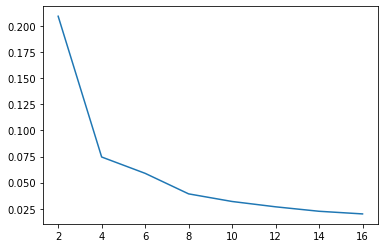

In [4]:
plt.plot(num_hilos, s)

In [47]:
import time

balance = 200
trans = 100000

def deposito():
    global balance
    balance = balance + 1
    
def retiro():
    global balance
    balance = balance - 1

t = time.time()     
for tr in range(trans):
    deposito()
    retiro()
    
print(balance)
print(time.time()- t)

200
0.033653974533081055


In [ ]:

# inicia los hilos
t = time.time()
d = threading.Thread(target=deposit, args=())
w = threading.Thread(target=withdraw, args=())
d.start()
w.start()
d.join()
w.join()
print('Tiempo de ejecucion', time.time()-t)
#print(balance)

---

In [252]:
# Importing the threading module
import threading 
deposit = 100
# Function to add profit to the deposit
def add_profit(): 
    global deposit
    for i in range(100000):
        deposit = deposit + 10
# Function to deduct money from the deposit
def pay_bill(): 
    global deposit
    for i in range(100000):
        deposit = deposit - 10
# Creating threads
thread1 = threading.Thread(target = add_profit, args = ())
thread2 = threading.Thread(target = pay_bill, args = ())
# Starting the threads
thread1.start() 
thread2.start()
# Waiting for both the threads to finish executing 
thread1.join()
thread2.join()
# Displaying the final value of the deposit
print(deposit)

100
